# Duplicate Images (on Training)

In [1]:
import cv2
import datetime
import gc
import glob
import imagehash
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import sys
import tqdm

In [2]:
def read_dicom_image(image_file, voi_lut=True, fix_monochrome=True):
    """
    Reads a dicom image from a file an returns a numpy array.
    """
    dicom = pydicom.read_file(image_file)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # Fix X-ray:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data


def string2boxes(string):
    strings = string.split()
    if strings[0].lower() == 'none':
        return []
    else:
        return [{'class': strings[idx],
                 'conf': float(strings[idx+1]),
                 'x1': float(strings[idx+2]),
                 'y1': float(strings[idx+3]),
                 'x2': float(strings[idx+4]),
                 'y2': float(strings[idx+5]),
                 } for idx in range(0, len(strings), 6)]


def plot_image(image, boxes=None, size=(5,5), title=None, columns=4):
    def plot_img(image, boxes=None, title=None):
        if isinstance(image, str):
            image_id = os.path.splitext(os.path.split(image)[1])[0]
            df = df_image.loc[df_image['id'] == image_id + '_image']
            boxes = string2boxes(df['label'].iloc[0]) if len(df) > 0 else None
            image = read_dicom_image(image)
        image = np.stack([image] * 3, axis=-1)
        if boxes is not None:
            for box in boxes:
                image = cv2.rectangle(image, (int(box['x1']), int(box['y1'])), (int(box['x2']), int(box['y2'])), [0, 255, 0], 10)
        plt.axis('on')
        plt.imshow(image, cmap='gray')
        if title is not None:
            plt.title(title)

    plt.figure(figsize=size)
    if isinstance(image, list):
        num = len(image)
        columns = min(columns, num)
        rows = math.ceil(num / columns)

        for index, single_image in enumerate(image):
            plt.subplot(rows, columns, index + 1)
            plot_img(single_image, boxes=boxes, title=title[index])
    else:
        plot_img(image, boxes=boxes, title=title)
    plt.show()


def images_find_duplicates(image_files, threshold=0.9):
    funcs = [imagehash.average_hash, imagehash.phash, imagehash.dhash, imagehash.whash]
    image_ids = image_files
    hashes = []
    for file in tqdm.tqdm(image_files):
        image = PIL.Image.fromarray(read_dicom_image(file))
        hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))
    hashes_all = np.array(hashes)

    # Note: Comparisons without Pytorch
    sim_list = []
    for i in tqdm.tqdm(range(hashes_all.shape[0])):
        sim_list.append(np.sum(hashes_all[i] == hashes_all, axis=1)/256)

    similarities = np.triu(np.array(sim_list), 1)

    idx_pair = np.where(similarities > threshold)
    df_pairs = pd.DataFrame({'image1': [image_ids[i] for i in list(idx_pair[0])],
                             'image2': [image_ids[i] for i in list(idx_pair[1])],
                             'similarity': [similarities[i1, i2] for i1, i2 in zip(idx_pair[0], idx_pair[1])]})

    idx_group = np.zeros(len(image_files))
    group_id = 1
    for i1, i2 in zip(idx_pair[0], idx_pair[1]):
        if idx_group[i1] == 0 and idx_group[i2] == 0:
            idx_group[i1] = group_id
            idx_group[i2] = group_id
            group_id += 1
        elif idx_group[i1] != 0 and idx_group[i2] == 0:
            idx_group[i2] = idx_group[i1]
        elif idx_group[i1] == 0 and idx_group[i2] != 0:
            idx_group[i1] = idx_group[i2]
        elif idx_group[i1] != 0 and idx_group[i2] != 0 and idx_group[i1] != idx_group[i2]:
            common_id = min(idx_group[i1], idx_group[i2])
            idx_group[idx_group == idx_group[i1]] = common_id
            idx_group[idx_group == idx_group[i2]] = common_id

    group_list = []
    for i in range(1, group_id + 1):
        group_ids = list(np.where(idx_group == i)[0])
        if len(group_ids) > 0:
            group_list.append([image_ids[j] for j in group_ids])

    return df_pairs, group_list

### Finding duplicates on training (without PyTorch)

In [5]:
train_files = sorted(glob.glob('train/*/*/*.dcm'))
print(f'Number of training files: {len(train_files)}')
df_image = pd.read_csv('train_image_level.csv')
df_study = pd.read_csv('train_study_level.csv')
df_study['study_label'] = df_study.apply(lambda r: ', '.join([df_study.columns[i] for i in range(1, 5) if r[i] > 0]), axis=1)

df_pairs, group_list = images_find_duplicates(train_files, threshold=0.95)
print(f'\nNumber of duplicate pairs: {len(df_pairs)}')
print(f'Number of duplicate groups: {len(group_list)}')

  0%|          | 0/6079 [00:00<?, ?it/s]

Number of training files: 6079


 10%|█         | 630/6079 [05:48<47:33,  1.91it/s]  /home/gusmendez99/anaconda3/lib/python3.8/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)
100%|██████████| 6079/6079 [00:14<00:00, 416.10it/s]



Number of duplicate pairs: 176
Number of duplicate groups: 70


In [6]:
df_group_list = []
df_pairs.to_csv('pairs.csv')

def print_group_info(i, df_group):
    print(f'\nGroup {i+1}')
    print(f'Unique studies:       {len(df_group["study_id"].unique())}')
    print(f'Unique study labels:  {len(df_group["study_label"].unique())}\n')
    print(df_group[['image_id', 'num_boxes', 'study_id', 'study_label']])
    plot_image(list(df_group['image_file']), size=(20, 10), title=list(df_group['image_id']), columns=8)

# Open duplicates.csv files to extract info
with open('duplicates.csv', 'w') as text_file:
    for i, group in enumerate(group_list):
        group_ids = [os.path.splitext(os.path.basename(file))[0] + '_image' for file in group]
        df_group_ids = pd.DataFrame({'id': group_ids, 'image_file': group})
        df_group = df_group_ids.merge(df_image, on='id').sort_values('id')
        df_group['study_id'] = df_group['StudyInstanceUID'] + '_study'
        df_group['num_boxes'] = df_group.apply(lambda r: len(string2boxes(r['label'])), axis=1)
        df_group = df_group.merge(df_study, left_on='study_id', right_on='id')
        df_group = df_group.rename(columns={'id_x': 'image_id'})
        df_group_list.append(df_group)
        text_file.write(','.join(group_ids) + '\n')

### Show duplicated images by multiple params

#### Bouding boxes in more than a single image


Group 10
Unique studies:       2
Unique study labels:  2

             image_id  num_boxes            study_id          study_label
0  7b7275d670e7_image          1  cbe5d39a75bd_study  Atypical Appearance
1  c8156ae4d6e8_image          2  10e35f64fc16_study   Typical Appearance


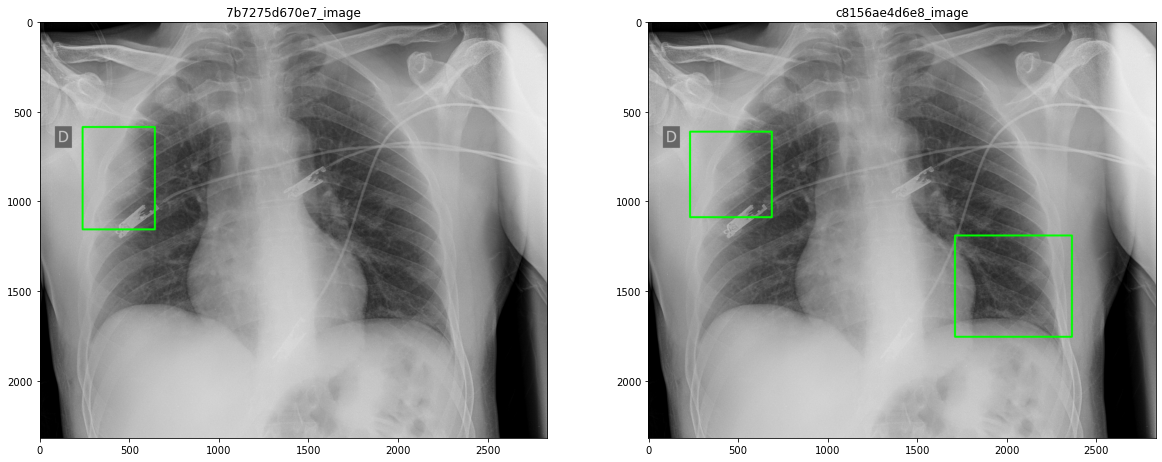

In [8]:
for index, df_group in enumerate(df_group_list):
    if len(df_group[df_group['num_boxes'] > 0]) > 1:
        print_group_info(index, df_group)

#### More than a single Study Label


Group 10
Unique studies:       2
Unique study labels:  2

             image_id  num_boxes            study_id          study_label
0  7b7275d670e7_image          1  cbe5d39a75bd_study  Atypical Appearance
1  c8156ae4d6e8_image          2  10e35f64fc16_study   Typical Appearance


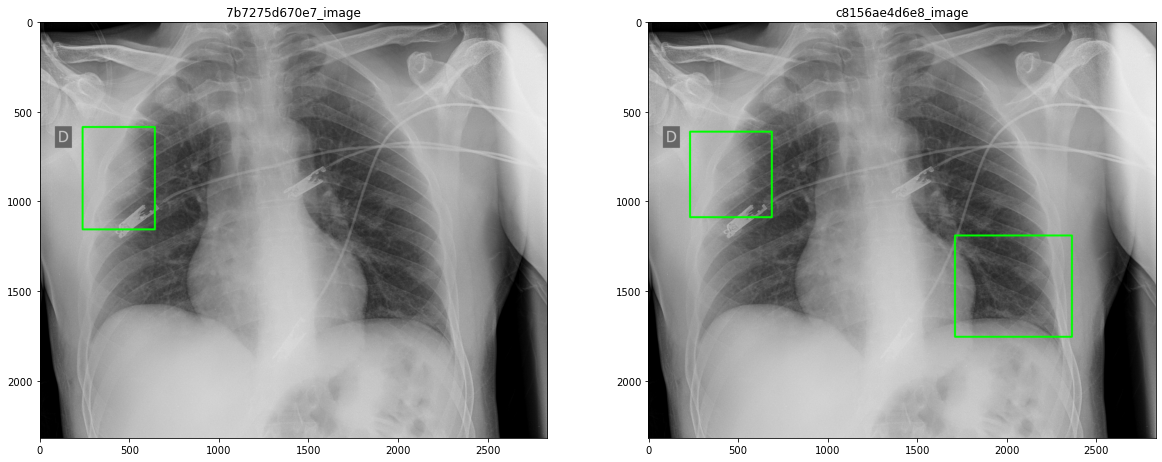

In [9]:
for index, df_group in enumerate(df_group_list):
    if len(df_group['study_label'].unique()) > 1:
        print_group_info(index, df_group)

#### More than a single study


Group 10
Unique studies:       2
Unique study labels:  2

             image_id  num_boxes            study_id          study_label
0  7b7275d670e7_image          1  cbe5d39a75bd_study  Atypical Appearance
1  c8156ae4d6e8_image          2  10e35f64fc16_study   Typical Appearance


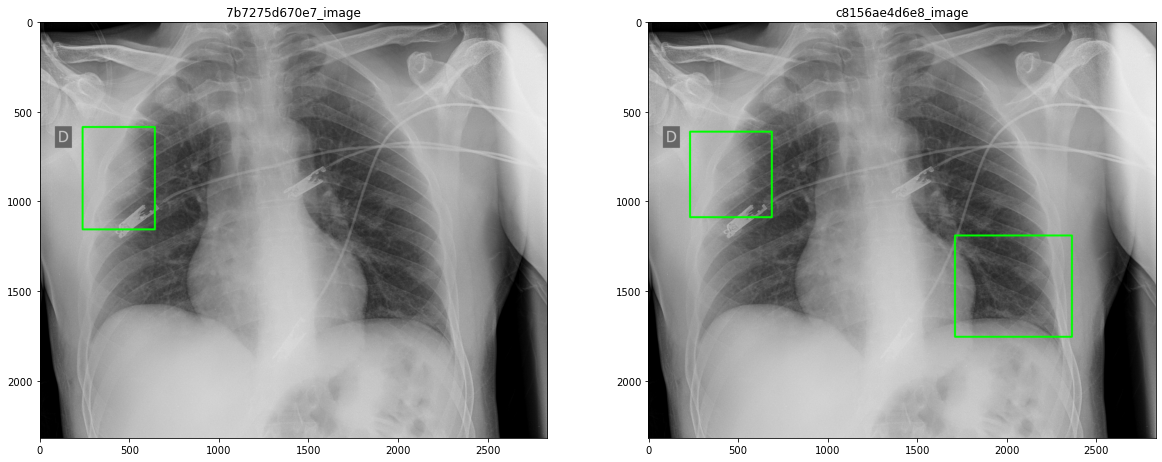


Group 12
Unique studies:       2
Unique study labels:  1

             image_id  num_boxes            study_id         study_label
0  00c1515729a8_image          0  1a58b43cf286_study  Typical Appearance
1  9e844dea386a_image          2  c5ae5513399f_study  Typical Appearance


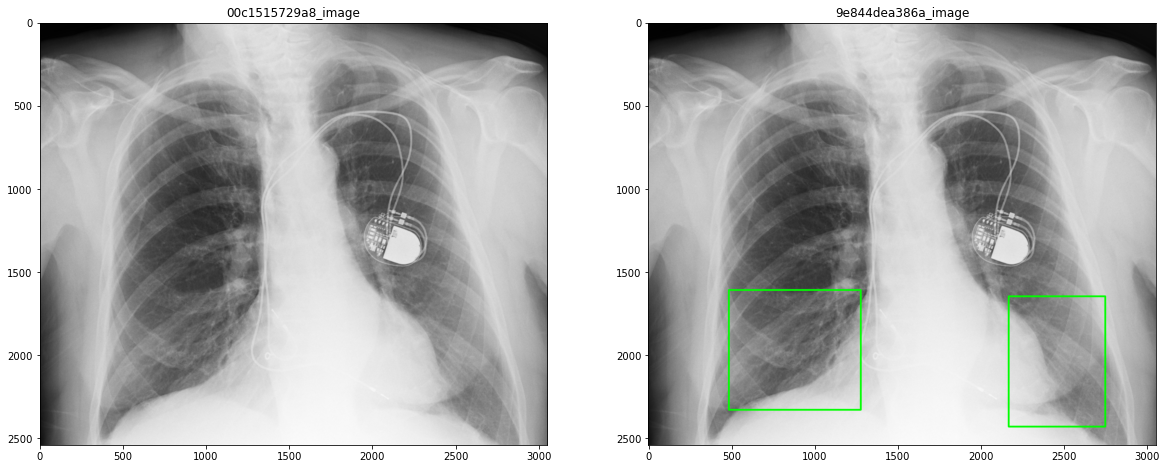


Group 23
Unique studies:       2
Unique study labels:  1

             image_id  num_boxes            study_id         study_label
0  2c130ee08736_image          0  4ebaaa8b1eb2_study  Typical Appearance
1  684230477525_image          0  4ebaaa8b1eb2_study  Typical Appearance
2  d93b8a8335cf_image          2  bc3e009078ca_study  Typical Appearance


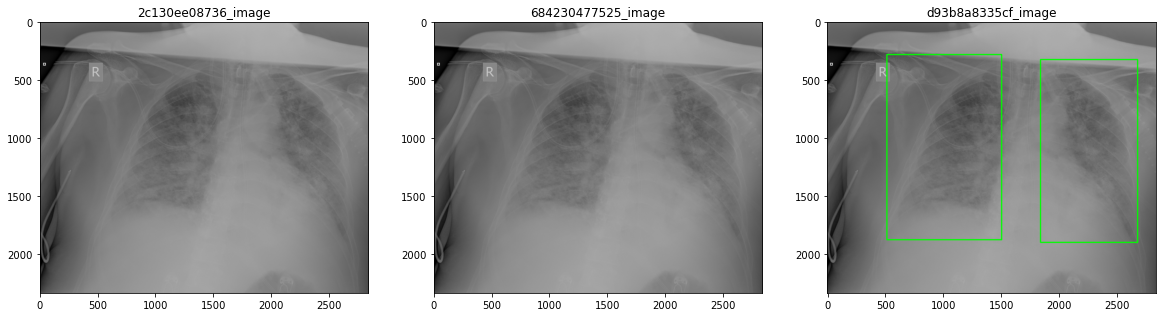


Group 39
Unique studies:       2
Unique study labels:  1

             image_id  num_boxes            study_id         study_label
0  7be323e5f816_image          2  c65ed6750934_study  Typical Appearance
1  be65d1a22de5_image          0  8f08039e8b7f_study  Typical Appearance
2  c843d08b49b8_image          0  8f08039e8b7f_study  Typical Appearance


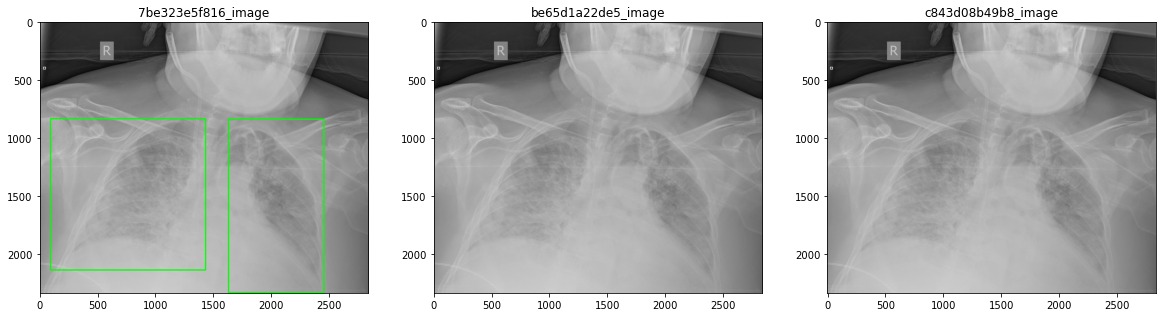

In [10]:
with open('duplicates_study.csv', 'w') as text_file:
    for index, df_group in enumerate(df_group_list):
        if len(df_group['study_id'].unique()) > 1:
            print_group_info(index, df_group)
            text_file.write(','.join(list(df_group['study_id'].unique())) + '\n')

### Summary of Duplicate Images

In [11]:
print('Total duplicate images: ', len(df_group_list))

Total duplicate images:  70


#### Plot some Duplicate Images (Human Double-Check)


Group 1
Unique studies:       1
Unique study labels:  1

             image_id  num_boxes            study_id          study_label
0  6534a837497d_image          0  00f9e183938e_study  Atypical Appearance
1  74077a8e3b7c_image          3  00f9e183938e_study  Atypical Appearance


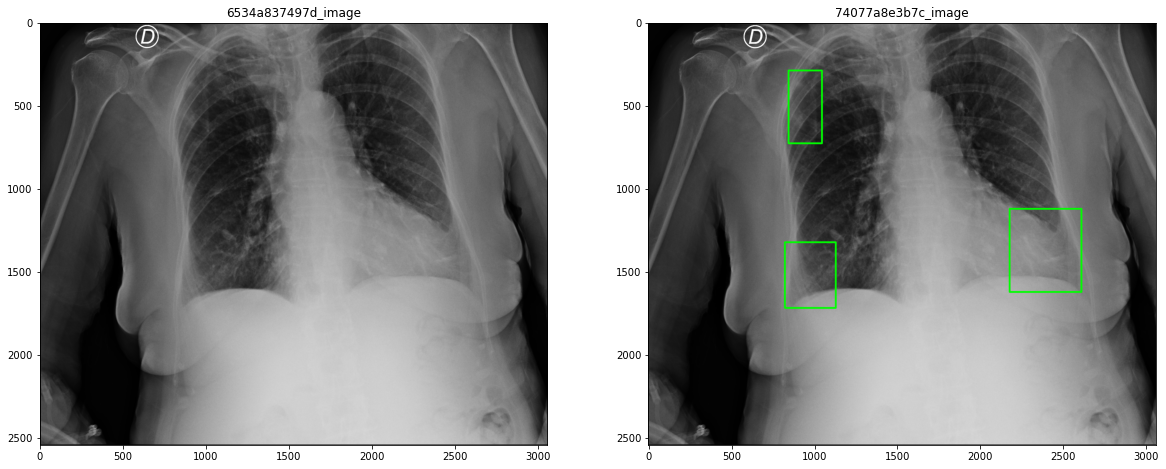


Group 11
Unique studies:       1
Unique study labels:  1

             image_id  num_boxes            study_id         study_label
0  72cf260ddf4c_image          0  172e2caf0eb4_study  Typical Appearance
1  93979c3e3177_image          2  172e2caf0eb4_study  Typical Appearance


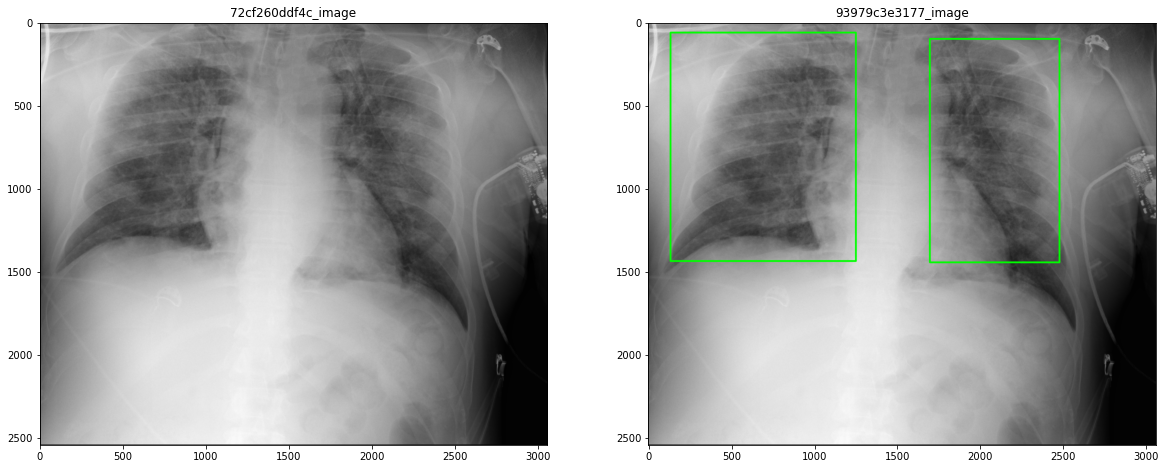


Group 21
Unique studies:       1
Unique study labels:  1

             image_id  num_boxes            study_id             study_label
0  7966f780f27f_image          0  47a8d29668f2_study  Negative for Pneumonia
1  93301812b0e7_image          0  47a8d29668f2_study  Negative for Pneumonia


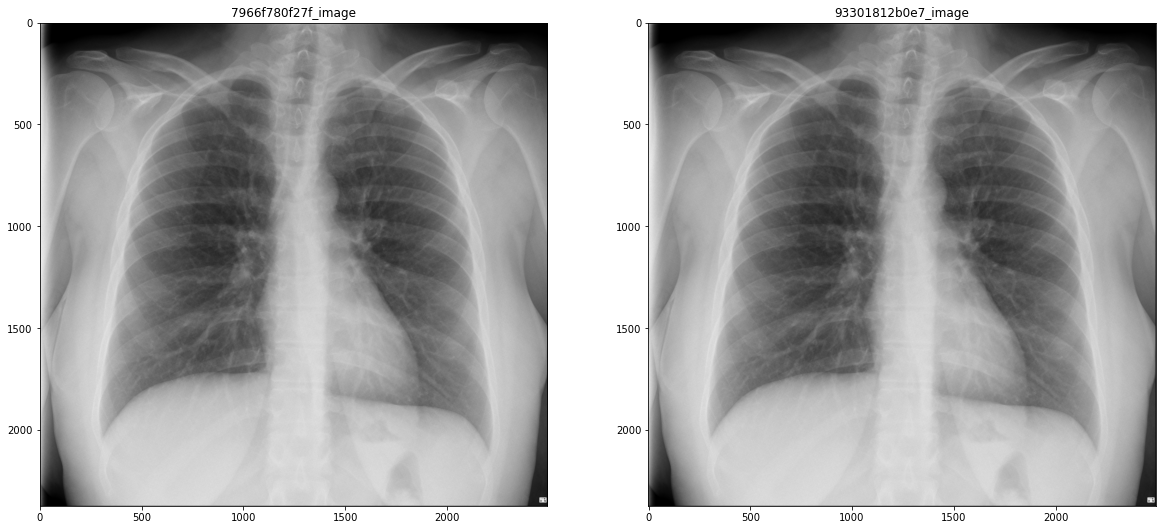


Group 31
Unique studies:       1
Unique study labels:  1

             image_id  num_boxes            study_id          study_label
0  1b92142f4362_image          0  76b5e2db22ba_study  Atypical Appearance
1  fa447a409bd6_image          1  76b5e2db22ba_study  Atypical Appearance


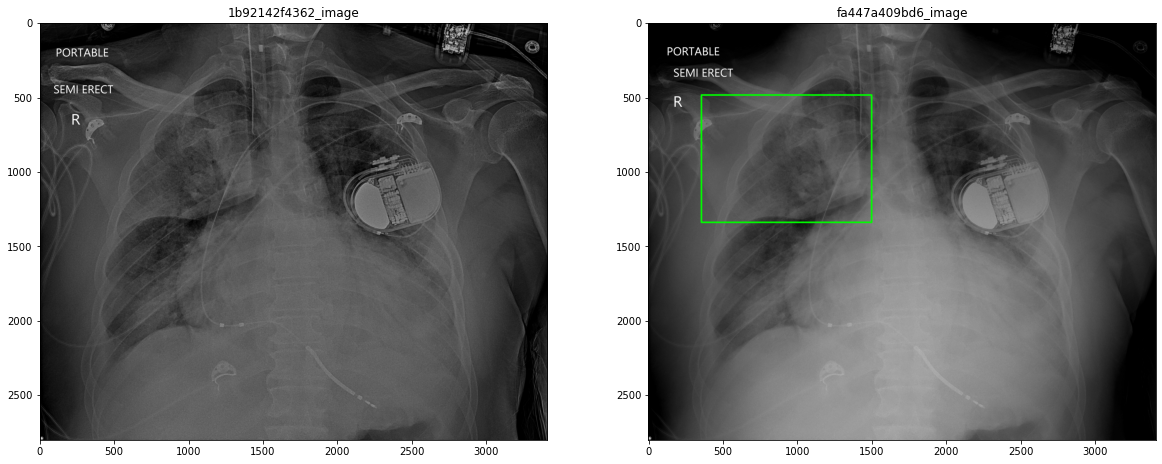


Group 41
Unique studies:       1
Unique study labels:  1

             image_id  num_boxes            study_id         study_label
0  19701de5ae89_image          2  8ffea46ac1bc_study  Typical Appearance
1  9fcbe25a88e0_image          0  8ffea46ac1bc_study  Typical Appearance


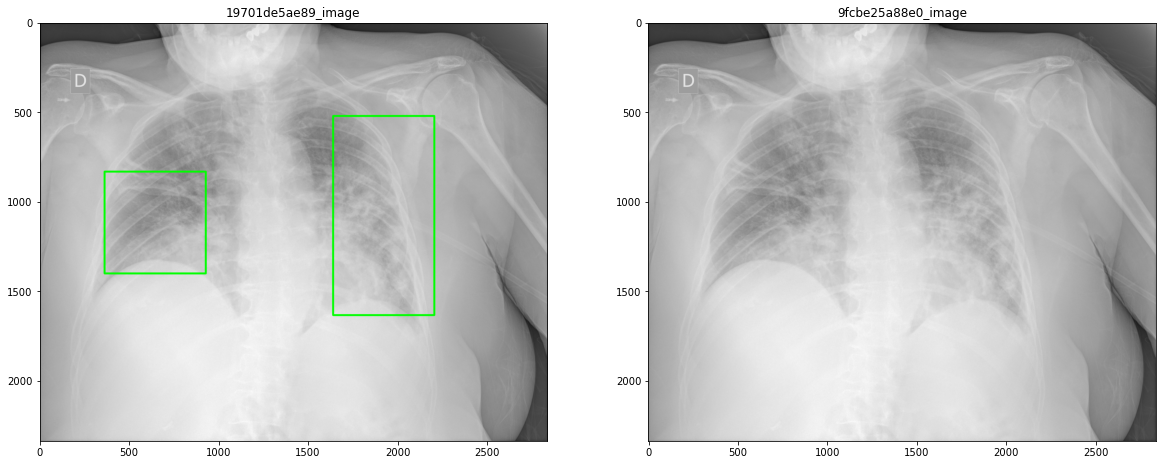


Group 51
Unique studies:       1
Unique study labels:  1

             image_id  num_boxes            study_id               study_label
0  847f48f57169_image          1  a90de7edd9b7_study  Indeterminate Appearance
1  ef6e312ca719_image          0  a90de7edd9b7_study  Indeterminate Appearance


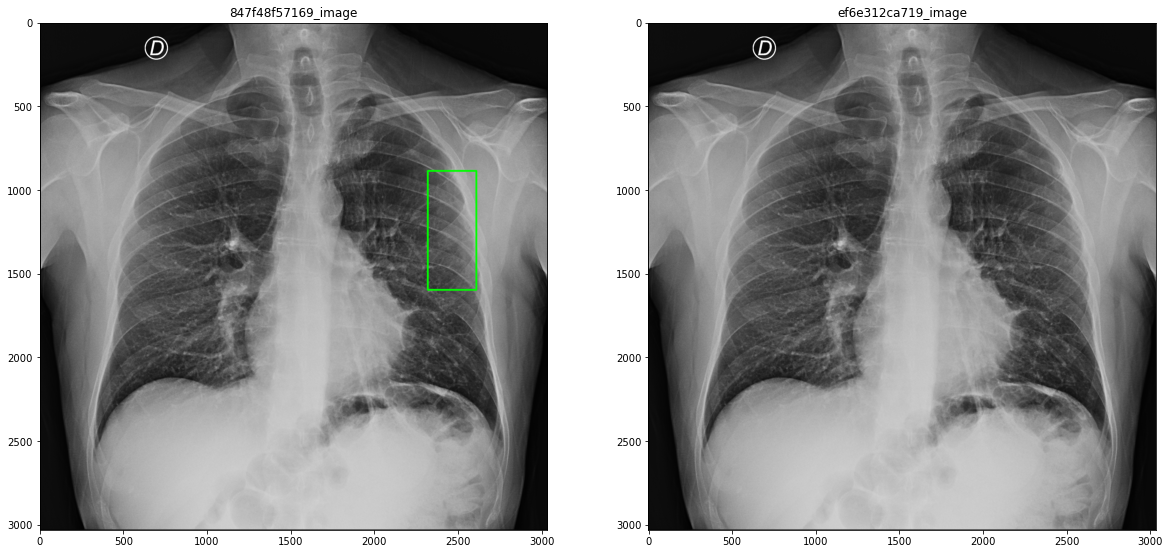


Group 61
Unique studies:       1
Unique study labels:  1

             image_id  num_boxes            study_id               study_label
0  2f6019c75d6d_image          1  d422862db292_study  Indeterminate Appearance
1  df2bb22fa871_image          0  d422862db292_study  Indeterminate Appearance


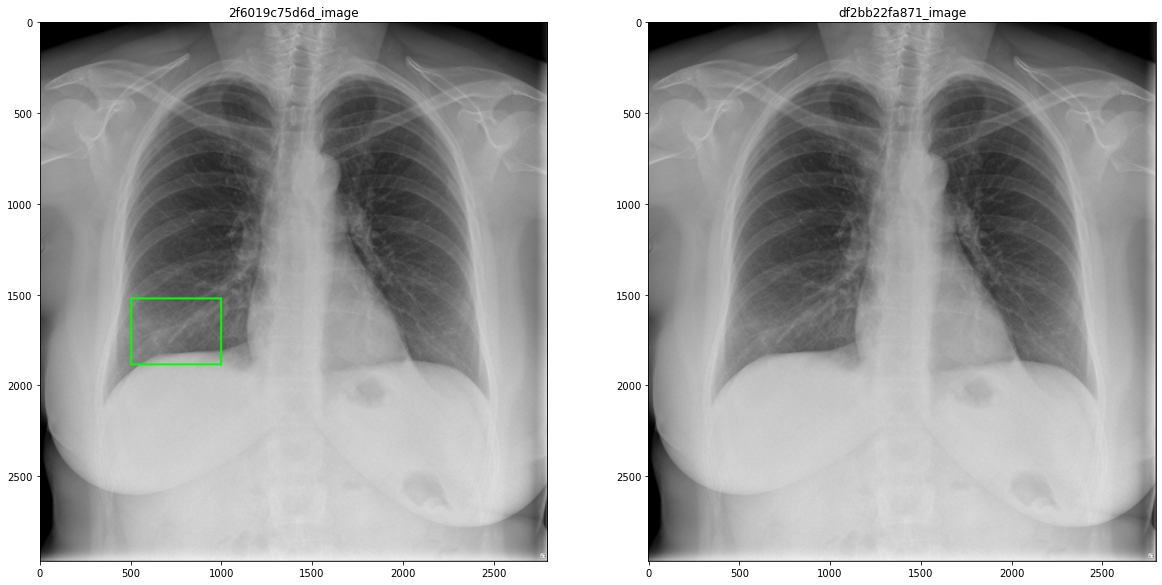

In [12]:
for index, df_group in enumerate(df_group_list):
    if index % 10 == 0:
        print_group_info(index, df_group)

### Conclusion

We have already identified some duplicated images & duplicated studies based on Image Hashes (Image hashes tell whether two images look nearly identical) and saved them on the **duplicates.csv** and **duplicates_study.csv**, respectively. So, this would be useful in the next steps to remove some duplicated images before the preprocessing step...